In [25]:
import torch
import torch.nn as nn 
from torchvision import models, datasets, transforms
from torchvision.models import VGG19_BN_Weights
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import cv2
import os
import sys
sys.path.append('C:\WorkSpace\KDT\TORCH_IMAGE\MyModule\MyModule')
from KDTModule import *

In [26]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

# 이미지 회전해서 증강하기

# 원본 이미지 경로
ROOT_PATH = '../../../LocalData/pj_09_DL/train'
# 회전된 이미지 경로
SAVE_PATH_90 = '../../../LocalData/pj_09_DL/train2'

# ImageFolder 사용
DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

originDS = datasets.ImageFolder(root=ROOT_PATH)

for i in range(len(originDS)):
    for j in [0, 90, 180, 270]:
        class_name = DS.classes[DS[i][1]]
        FILE_PATH = os.path.join(SAVE_PATH_90, class_name, f'img_index{i}_{j}.jpg')
        FILE_PATH2 = os.path.join(SAVE_PATH_90, class_name, f'flip_img_index{i}_{j}.jpg')
        rotate_img = originDS[i][0].rotate(j, expand=True)
        flipped_img = rotate_img.transpose(Image.FLIP_LEFT_RIGHT)
        rotate_img.save(FILE_PATH)
        flipped_img.save(FILE_PATH2)

# DataLoader
DL = DataLoader(DS, batch_size = 32, shuffle=True)

print(DS.classes)
print(f'데이터 개수 : {len(DL.dataset)}')

['1', '2', '3', '4', '5']
데이터 개수 : 23240


In [27]:
dataset_size = len(DS)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# train, valid 나누기
train_dataset, valid_dataset = random_split(DS, [train_size, valid_size])

In [28]:
trainDL = DataLoader(train_dataset, batch_size = 32)
validDL = DataLoader(valid_dataset, batch_size = 32)

print(f"[train] : {len(trainDL.dataset)}, [test] : {len(validDL.dataset)}")

[train] : 18592, [test] : 4648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


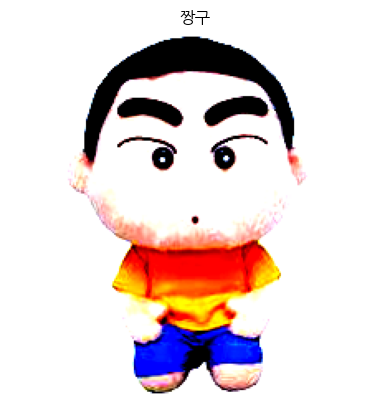

In [29]:
name_dict = {0 : '짱구', 1 : '철수', 2: '훈이' , 3 : '맹구', 4 : '유리'}

INDEX = 100

a = DL.dataset[INDEX][0].permute(1,2,0)
plt.axis('off')
plt.title(name_dict[DL.dataset[INDEX][1]])
plt.imshow(a)
plt.show()

In [30]:
# GPU 사용 가능 여부 확인 
if torch.cuda.is_available():
    print('GPU')
    device = torch.device("cuda")
else:
    print('CPU')
    device = torch.device("cpu")

# 미리 학습된 Vgg 모델 불러오기 (weight 사용)
model = models.vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).to(device)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

CPU


In [31]:
# 마지막 레이어 (full connected layer) 교체 (클래스 5개로 변경)
num_features = model.classifier[0].in_features # 2048
model.classifier = nn.Linear(num_features, 5) # 입력은 이전 층의 아웃을 그대로 받고 출력은 방법대 인원

# 손실 함수와 옵티마이저 정의
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [32]:
trainDL.dataset[0][0].shape

torch.Size([3, 224, 224])

In [33]:
trainDL.dataset[0][1]

0

In [34]:
EPOCH = 100
SAVE_PATH = '../../../LocalData/pj_09_DL/model'

result=training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer,
         epoch = EPOCH, endurance_cnt = 5, view_epoch = 1, num_classes = 5, SAVE_PATH = SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.3439, Test : 0.1911
[Score  : 1/100] Train : 0.8791, Test : 0.9307
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.0726, Test : 0.1572
[Score  : 2/100] Train : 0.9769, Test : 0.9448


<function matplotlib.pyplot.show(close=None, block=None)>

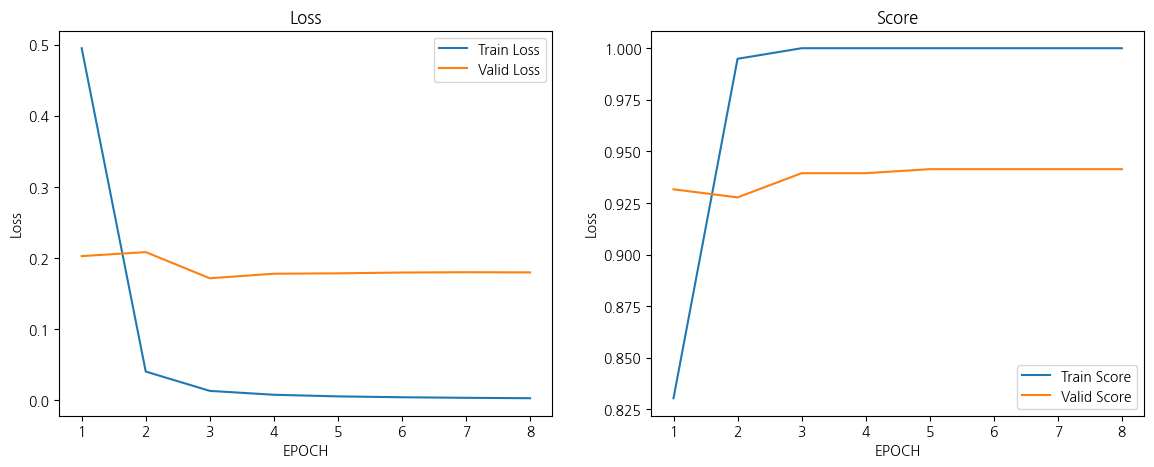

In [23]:
DrawPlot(result)
plt.show